# **Please note you need a GPU with at least 24GB memory to test this 3D turbulence generation**

# Imports

In [7]:
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


In [ ]:
import torch
import numpy as np
from functools import partial
import sys
sys.path.append("../../../..")
from ConditionalDiffusionGeneration.src.guided_diffusion.unet import create_model
from ConditionalDiffusionGeneration.src.guided_diffusion.condition_methods import get_conditioning_method
from ConditionalDiffusionGeneration.src.guided_diffusion.measurements import get_noise, get_operator
from ConditionalDiffusionGeneration.src.guided_diffusion.gaussian_diffusion import create_sampler
from ConditionalNeuralField.cnf.inference_function import ReconstructFrame, decoder
from einops import rearrange

In [9]:
if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = "cpu"

device = torch.device(dev)

In [10]:
torch.manual_seed(42)
np.random.seed(42)

# Conditioning Data Loader

In [11]:
no_of_sensors = 10 #1,10,100,1000

In [12]:
true_measurement = torch.from_numpy(np.load(f'input/random_sensor/{no_of_sensors}/measures.npy')).to(device)

In [13]:
true_measurement.shape

torch.Size([384, 10, 3])

# Load trained unconditional model

In [15]:
u_net_model = create_model(image_size= 384,
                           num_channels= 128,
                           num_res_blocks= 2,
                           channel_mult = "1, 1, 2, 2, 4, 4",
                           num_heads=4,
                           num_head_channels=64,
                           attention_resolutions="32,16,8",
                           model_path='./input/diff_model/ema_0.9999_400000.pt'
                        );

u_net_model.to(device);
u_net_model.eval();

# Operator and Noise

In [18]:
operator =  get_operator(device=device, name='case4',
                         coords_path=f'input/random_sensor/{no_of_sensors}/coords.npy',\
                         max_val_path="input/data_scale/data_max.npy",\
                         min_val_path="input/data_scale/data_min.npy",\
                         normalizer_params_path="input/cnf_model/Hirachical2-11-11_normalizer_params.pt",\
                         ckpt_path="input/cnf_model/checkpoint_20000.pt",
                         batch_size=384)

In [19]:
noiser = get_noise(sigma=0.0, name='gaussian')

## For masking in time

In [20]:
# start, stop, step = 0, 257, 5
mask = torch.ones_like(true_measurement, device=device)
# mask[start:stop:step] = 1

# Conditioning Method

In [21]:
cond_method = get_conditioning_method(operator=operator, noiser=noiser, name='ps', scale=1.)
measurement_cond_fn = partial(cond_method.conditioning)

# Sampler

In [22]:
sampler = create_sampler(sampler='ddpm',
                         steps=1000,
                         noise_schedule="cosine",
                         model_mean_type="epsilon",
                         model_var_type="fixed_large",
                         dynamic_threshold=False,
                         clip_denoised=True,
                         rescale_timesteps=False,
                         timestep_respacing="")

sample_fn = partial(sampler.p_sample_loop, model=u_net_model, measurement_cond_fn=measurement_cond_fn)

## Generate Samples

In [23]:
no_of_samples = 10
time_length = 384
latent_size = 384

In [24]:
x_start = torch.randn(no_of_samples, 1, time_length, latent_size, device=device)
samples = [sample_fn(x_start=x_start[i:i+1], measurement=mask*true_measurement, record=False, save_root=None) for i in range(x_start.shape[0])]

100%|██████████| 1000/1000 [01:47<00:00,  9.29it/s, distance=8.82]


In [25]:
gen_latents = torch.cat(samples)
gen_latents = operator._unnorm(gen_latents)
gen_latents = gen_latents[:,0]

# Decoding latents to flow fields

In [26]:
info = np.load("input/cnf_model/infos.npz")
coords = torch.tensor(np.load("input/cnf_model/coords.npy"), device=device, dtype=torch.float32)

In [27]:
xnorm  = operator.x_normalizer
ynorm  = operator.y_normalizer
model = operator.model
gen_latents_cnf_input = rearrange(gen_latents, "s t l -> (s t) l")

In [28]:
gen_fields = decoder(coords, gen_latents_cnf_input, model, xnorm, ynorm, batch_size=16, device=device)
gen_fields = rearrange(gen_fields, "(s t) co c -> s t co c", t=time_length)

# Post processing the flow fields for visualization

In [29]:
pred_data_list = []
for ss in range(no_of_samples):
    for kk in range(time_length):
        pred_data = gen_fields[ss, kk].cpu().numpy()
        pred_data = ReconstructFrame(pred_data, mask=info['Mask'], shape=info['reduced_shape'], fill_value = 0.)# <Nx,Ny,Nz, cout>
        pred_data_list.append(pred_data)

### The generated 3D flow fields

* saved with shape [samples, time, x, y, z, vars].
    * vars includes 3 velocity components, u, v, w.

In [30]:
pred_data_list = rearrange(np.stack(pred_data_list), "(s t) x y z c -> s t x y z c", t=time_length)

# Comparison of sensor plots

In [31]:
from numpy.random import default_rng
import matplotlib.pyplot as plt
import pylab
params = {'legend.fontsize': 25,'axes.labelsize': 25,'axes.titlesize':25,'xtick.labelsize':25,'ytick.labelsize':25}
pylab.rcParams.update(params)

In [32]:
rng = default_rng(seed=56)
train_probes = rng.choice(gen_fields.shape[2], size=no_of_sensors, replace=False)

In [33]:
gen_Umag = torch.sqrt((gen_fields**2).sum(axis=-1)).detach().cpu()

In [34]:
meand, stdd = torch.mean(gen_Umag, dim=0), torch.std(gen_Umag, dim=0)

In [35]:
train_data_Umag = torch.sqrt((true_measurement**2).sum(axis=-1)).detach().cpu()

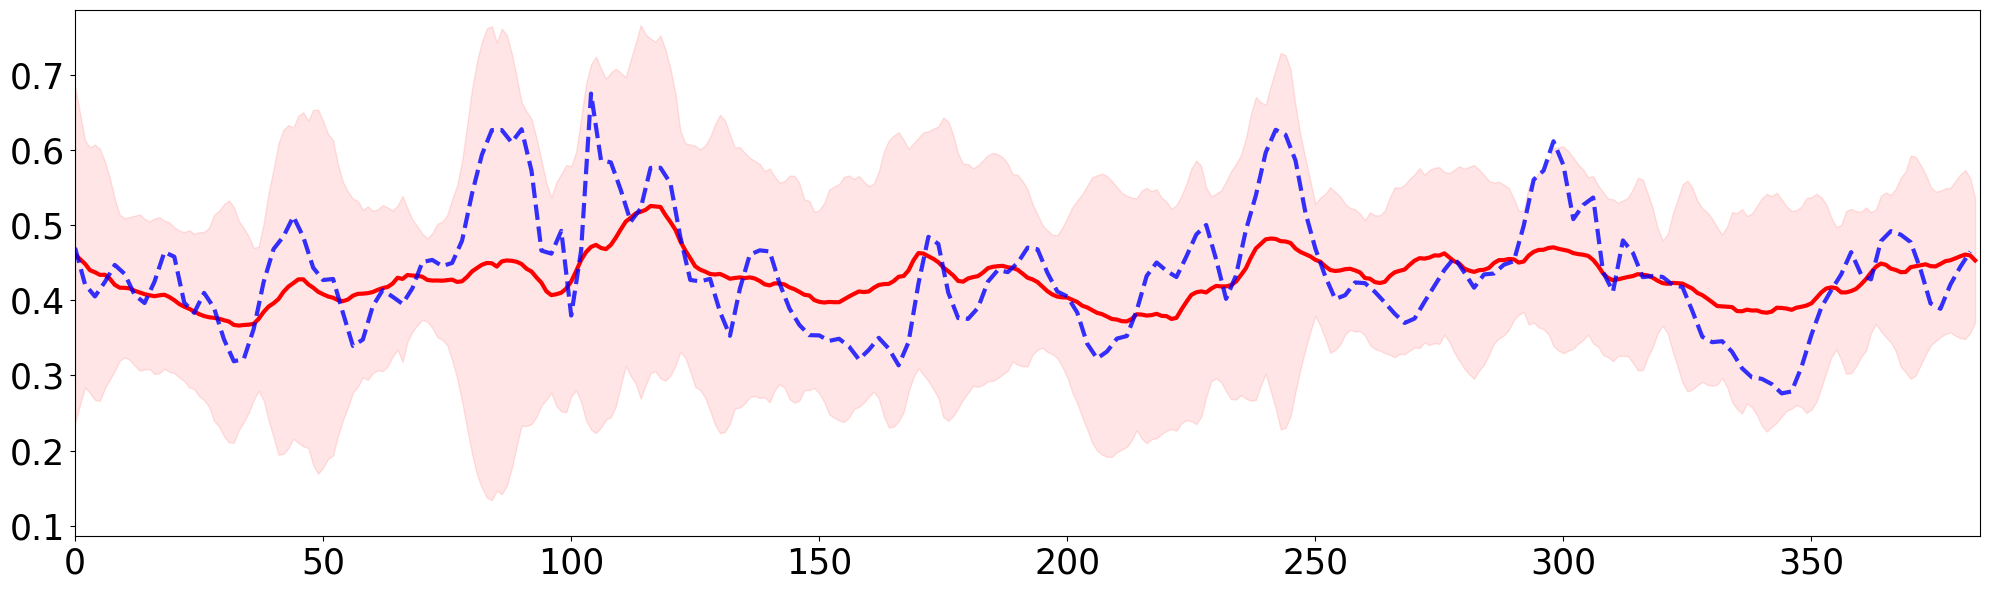

In [36]:
for probe in train_probes[:1]:
    range_ = 0.7
    scale = 3
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,6))
    for _ in range(1):
        uncer_up_lim, uncer_down_lim = meand + scale*stdd, meand - scale*stdd
        axes.fill_between(np.arange(384), (uncer_up_lim)[:, probe], (uncer_down_lim)[:, probe], color='red', alpha=0.1)
        axes.plot(meand[:,  probe], color='red', linewidth=3)
        axes.plot(np.arange(384)[::2], train_data_Umag[::2, 0], "--",linewidth=3, alpha=0.8, color='blue')
        mean_gt_Umag = train_data_Umag[:, 0].mean()
        axes.set_ylim([mean_gt_Umag - range_/2 ,mean_gt_Umag + range_/2])
        axes.set_xlim([0,384])
    fig.tight_layout()
    plt.show()

dashed blue line represents the sensor measurements, red line is the mean of all generated samples at the sensor location. The shaded area is the uncertainty corresponding to $3 \sigma$.